# Histopathologic Cancer Detection

### Kaggle Competition: Binary Image Classification for Metastatic Cancer Detection

## 1. Problem and Data Description

### Medical and Machine Learning Problem

This competition focuses on **detecting metastatic cancer** in small image patches extracted from histopathologic scans of lymph node sections. Metastatic cancer occurs when cancer cells spread from their original site to lymph nodes, and early detection is critical for treatment planning and prognosis.

The dataset is derived from the **PatchCamelyon (PCam) benchmark**, which consists of 96×96 pixel patches extracted from larger whole-slide images of lymph node tissue stained with hematoxylin and eosin (H&E).

### Binary Classification Setup

Each image patch is labeled based on whether the **central 32×32 pixel region** contains any tumor tissue:
- **Label 0 (Negative)**: No tumor tissue in the central 32×32 region
- **Label 1 (Positive)**: Tumor tissue present in the central 32×32 region

The surrounding 32-pixel border provides contextual information that helps convolutional neural networks make predictions, even though it doesn't directly determine the label.

### Evaluation Metric

Kaggle evaluates submissions using **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)** between predicted probabilities and binary labels. This metric is ideal for binary classification tasks as it measures the model's ability to discriminate between classes across all possible thresholds.

## 2. Data Loading and Basic Checks

I'll load the training labels and verify that all referenced images exist in the data directories.

In [19]:
import random
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.backends.mps.is_available():
    print("MPS (Apple Silicon) available: True")

PyTorch version: 2.9.1
CUDA available: False
MPS (Apple Silicon) available: True


In [20]:
# Define data paths
DATA_DIR = Path('../data')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
TRAIN_LABELS_PATH = DATA_DIR / 'train_labels.csv'
SAMPLE_SUBMISSION_PATH = DATA_DIR / 'sample_submission.csv'

# Verify directories exist
assert DATA_DIR.exists(), f"Data directory not found: {DATA_DIR}"
assert TRAIN_DIR.exists(), f"Train directory not found: {TRAIN_DIR}"
assert TEST_DIR.exists(), f"Test directory not found: {TEST_DIR}"
assert TRAIN_LABELS_PATH.exists(), f"Train labels not found: {TRAIN_LABELS_PATH}"

print("All data paths verified successfully!")

All data paths verified successfully!


In [21]:
# Load training labels
train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)

print("=" * 50)
print("Training Labels Overview")
print("=" * 50)
print(f"\nShape: {train_labels_df.shape}")
print(f"\nData types:\n{train_labels_df.dtypes}")
print(f"\nFirst 5 rows:")
display(train_labels_df.head())
print(f"\nLabel statistics:")
display(train_labels_df['label'].describe())

Training Labels Overview

Shape: (220025, 2)

Data types:
id       object
label     int64
dtype: object

First 5 rows:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



Label statistics:


count    220025.000000
mean          0.405031
std           0.490899
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: label, dtype: float64

In [22]:
# Construct full file paths for training images
train_labels_df['file_path'] = train_labels_df['id'].apply(
    lambda x: TRAIN_DIR / f"{x}.tif"
)

# Verify all training images exist
missing_train_files = train_labels_df[~train_labels_df['file_path'].apply(lambda x: x.exists())]

if len(missing_train_files) > 0:
    print(f"WARNING: {len(missing_train_files)} training files are missing!")
    print(missing_train_files.head())
else:
    print(f"All {len(train_labels_df)} training images verified to exist.")

All 220025 training images verified to exist.


In [23]:
# Get list of test images
test_image_files = list(TEST_DIR.glob('*.tif'))
test_ids = [f.stem for f in test_image_files]

print(f"Number of test images: {len(test_image_files)}")
print(f"Sample test IDs: {test_ids[:5]}")

# Verify test images exist
if len(test_image_files) == 0:
    print("WARNING: No test images found!")
else:
    print(f"All {len(test_image_files)} test images found.")

Number of test images: 57458
Sample test IDs: ['fd0a060ef9c30c9a83f6b4bfb568db74b099154d', '1f9ee06f06d329eb7902a2e03ab3835dd0484581', '19709bec800f372d0b1d085da6933dd3ef108846', '7a34fc34523063f13f0617f7518a0330f6187bd3', '93be720ca2b95fe2126cf2e1ed752bd759e9b0ed']
All 57458 test images found.


## 3. Exploratory Data Analysis (EDA)

I'll analyze the class distribution, visualize sample images from each class, and explore basic image statistics.

In [24]:
# Analyze label distribution
label_counts = train_labels_df['label'].value_counts().sort_index()
label_percentages = train_labels_df['label'].value_counts(normalize=True).sort_index() * 100

print("Label Distribution:")
print(f"  Class 0 (No Tumor):  {label_counts[0]:,} ({label_percentages[0]:.2f}%)")
print(f"  Class 1 (Tumor):     {label_counts[1]:,} ({label_percentages[1]:.2f}%)")
print(f"  Class Ratio (0:1):   {label_counts[0]/label_counts[1]:.2f}:1")

Label Distribution:
  Class 0 (No Tumor):  130,908 (59.50%)
  Class 1 (Tumor):     89,117 (40.50%)
  Class Ratio (0:1):   1.47:1


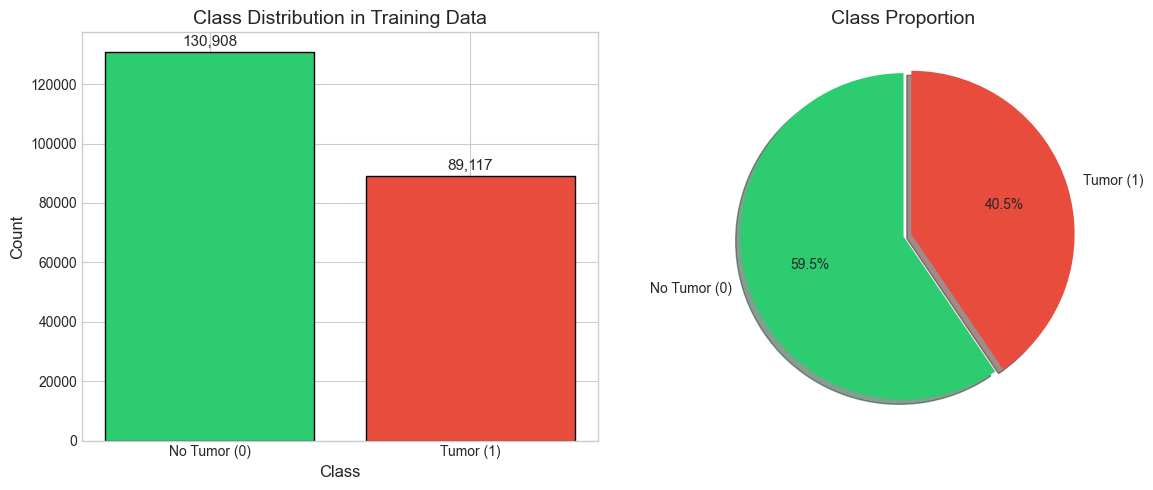

In [25]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['No Tumor (0)', 'Tumor (1)'], label_counts.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Class Distribution in Training Data', fontsize=14)
for bar, count in zip(bars, label_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                 f'{count:,}', ha='center', va='bottom', fontsize=11)

# Pie chart
axes[1].pie(label_counts.values, labels=['No Tumor (0)', 'Tumor (1)'], 
            autopct='%1.1f%%', colors=colors, explode=[0, 0.05],
            shadow=True, startangle=90)
axes[1].set_title('Class Proportion', fontsize=14)

plt.tight_layout()
plt.show()

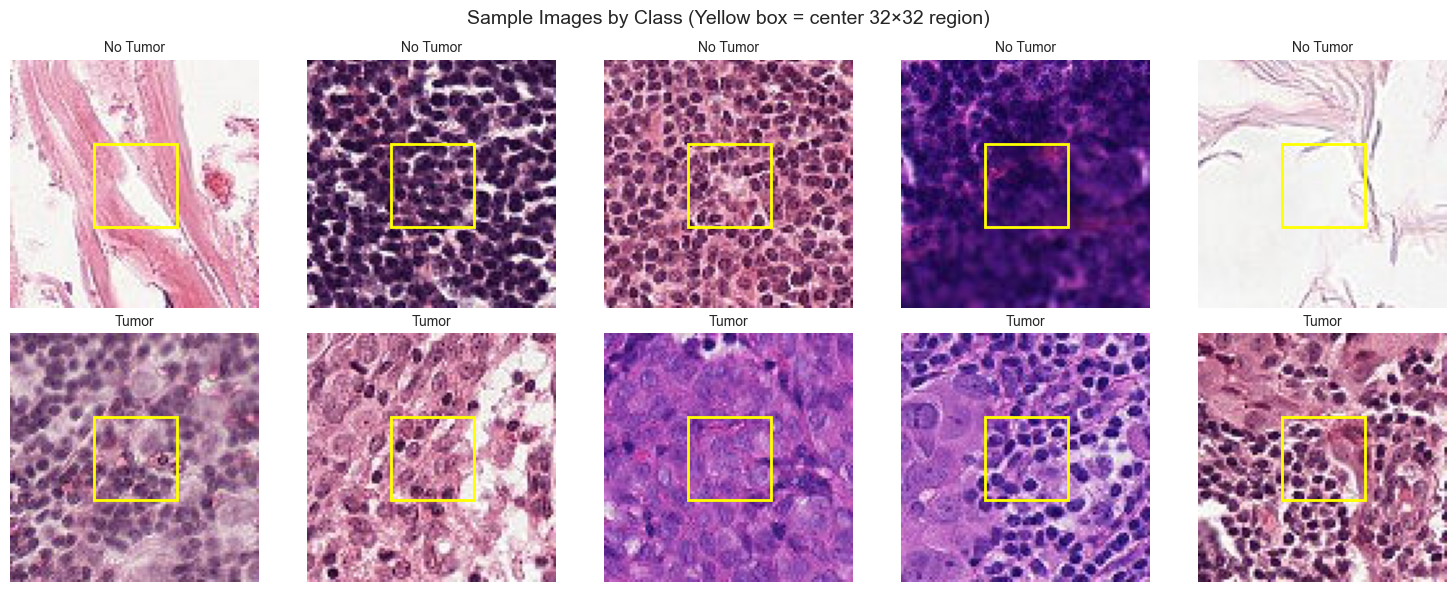

In [26]:
def load_image(file_path):
    """Load an image from file path."""
    return np.array(Image.open(file_path))


def display_sample_images(df, n_samples=5, figsize=(15, 6)):
    """Display random sample images from each class."""
    fig, axes = plt.subplots(2, n_samples, figsize=figsize)
    
    for row, label in enumerate([0, 1]):
        class_samples = df[df['label'] == label].sample(n=n_samples, random_state=SEED)
        class_name = "No Tumor" if label == 0 else "Tumor"
        
        for col, (_, sample) in enumerate(class_samples.iterrows()):
            img = load_image(sample['file_path'])
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'{class_name}', fontsize=10)
            axes[row, col].axis('off')
            
            # Draw center 32x32 region box
            rect = plt.Rectangle((32, 32), 32, 32, linewidth=2, 
                                  edgecolor='yellow', facecolor='none')
            axes[row, col].add_patch(rect)
    
    fig.suptitle('Sample Images by Class (Yellow box = center 32×32 region)', fontsize=14)
    plt.tight_layout()
    plt.show()

display_sample_images(train_labels_df)

In [27]:
# Analyze pixel-level statistics from a sample of images
def compute_image_statistics(df, n_samples=1000):
    """Compute channel-wise mean and std from a sample of images."""
    sample_df = df.sample(n=n_samples, random_state=SEED)
    
    all_pixels = []
    for _, row in sample_df.iterrows():
        img = load_image(row['file_path'])
        all_pixels.append(img)
    
    all_pixels = np.stack(all_pixels)
    
    # Compute per-channel statistics
    channel_means = all_pixels.mean(axis=(0, 1, 2))
    channel_stds = all_pixels.std(axis=(0, 1, 2))
    
    return channel_means, channel_stds, all_pixels

channel_means, channel_stds, sample_pixels = compute_image_statistics(train_labels_df)

print("Image Statistics (computed from 1000 random samples):")
print("  Image shape: 96 x 96 x 3 (RGB)")
print(f"  Channel means (R, G, B): [{channel_means[0]:.2f}, {channel_means[1]:.2f}, {channel_means[2]:.2f}]")
print(f"  Channel stds (R, G, B):  [{channel_stds[0]:.2f}, {channel_stds[1]:.2f}, {channel_stds[2]:.2f}]")
print(f"  Normalized means (0-1):  [{channel_means[0]/255:.4f}, {channel_means[1]/255:.4f}, {channel_means[2]/255:.4f}]")
print(f"  Normalized stds (0-1):   [{channel_stds[0]/255:.4f}, {channel_stds[1]/255:.4f}, {channel_stds[2]/255:.4f}]")

Image Statistics (computed from 1000 random samples):
  Image shape: 96 x 96 x 3 (RGB)
  Channel means (R, G, B): [177.98, 138.02, 176.00]
  Channel stds (R, G, B):  [61.02, 71.79, 55.88]
  Normalized means (0-1):  [0.6980, 0.5412, 0.6902]
  Normalized stds (0-1):   [0.2393, 0.2815, 0.2191]


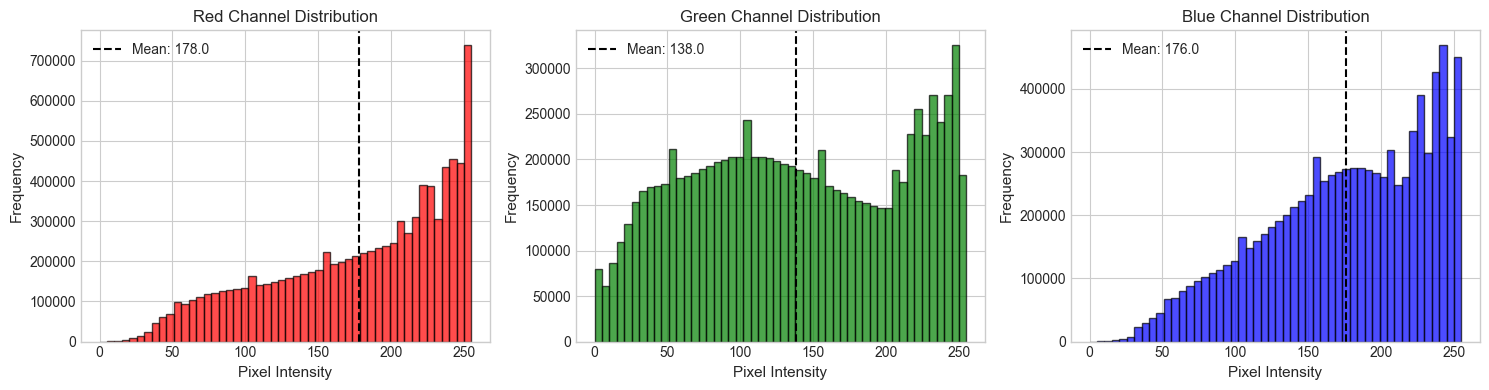

In [28]:
# Plot intensity histograms per channel
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
channel_names = ['Red', 'Green', 'Blue']
channel_colors = ['red', 'green', 'blue']

for i, (name, color) in enumerate(zip(channel_names, channel_colors)):
    channel_values = sample_pixels[:, :, :, i].flatten()
    axes[i].hist(channel_values, bins=50, color=color, alpha=0.7, edgecolor='black')
    axes[i].set_xlabel('Pixel Intensity', fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)
    axes[i].set_title(f'{name} Channel Distribution', fontsize=12)
    axes[i].axvline(channel_means[i], color='black', linestyle='--', 
                    label=f'Mean: {channel_means[i]:.1f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [29]:
# Split data into training and validation sets
# Using 80/20 stratified split to maintain class distribution
VALIDATION_SPLIT = 0.2

train_df, val_df = train_test_split(
    train_labels_df,
    test_size=VALIDATION_SPLIT,
    stratify=train_labels_df['label'],
    random_state=SEED
)

print(f"Data Split Summary:")
print(f"  Training set:   {len(train_df):,} samples ({(1-VALIDATION_SPLIT)*100:.0f}%)")
print(f"  Validation set: {len(val_df):,} samples ({VALIDATION_SPLIT*100:.0f}%)")
print(f"\nClass distribution after split:")
print(f"  Train - Class 0: {(train_df['label']==0).sum():,} | Class 1: {(train_df['label']==1).sum():,}")
print(f"  Val   - Class 0: {(val_df['label']==0).sum():,} | Class 1: {(val_df['label']==1).sum():,}")

Data Split Summary:
  Training set:   176,020 samples (80%)
  Validation set: 44,005 samples (20%)

Class distribution after split:
  Train - Class 0: 104,726 | Class 1: 71,294
  Val   - Class 0: 26,182 | Class 1: 17,823


The 80/20 split is a common choice that provides sufficient training data while reserving enough samples for reliable validation metrics. Stratified splitting ensures both sets maintain the same class proportions (~59% negative, ~41% positive).

## 4. Modeling and Training

I'll build a CNN model for binary classification, implement data augmentation, and train with proper validation tracking.

In [30]:
class HistopathologyDataset(Dataset):
    """PyTorch Dataset for histopathology image patches."""
    
    def __init__(self, dataframe, transform=None, is_test=False):
        """
        Args:
            dataframe: DataFrame with 'file_path' and optionally 'label' columns
            transform: Torchvision transforms to apply
            is_test: If True, no labels are expected
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Load image
        image = Image.open(row['file_path']).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, row['id']
        else:
            label = torch.tensor(row['label'], dtype=torch.float32)
            return image, label

In [31]:
# Define data augmentation transforms
# For histopathology, use:
# - Random horizontal/vertical flips (tissue orientation is arbitrary)
# - Random rotations (tissue can appear at any angle)
# - Slight color jitter (to account for staining variations)

# Normalization values computed from our dataset
NORM_MEAN = [channel_means[0]/255, channel_means[1]/255, channel_means[2]/255]
NORM_STD = [channel_stds[0]/255, channel_stds[1]/255, channel_stds[2]/255]

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

print("Data Augmentation Pipeline:")
print("  Training: RandomHorizontalFlip, RandomVerticalFlip, RandomRotation(20°), ColorJitter, Normalize")
print("  Validation/Test: Normalize only")
print("\nNormalization parameters:")
print(f"  Mean: {NORM_MEAN}")
print(f"  Std:  {NORM_STD}")

Data Augmentation Pipeline:
  Training: RandomHorizontalFlip, RandomVerticalFlip, RandomRotation(20°), ColorJitter, Normalize
  Validation/Test: Normalize only

Normalization parameters:
  Mean: [np.float64(0.6979647433278866), np.float64(0.5412409156284042), np.float64(0.690197487745098)]
  Std:  [np.float64(0.2393047732098867), np.float64(0.28151559871290205), np.float64(0.21913836582150986)]


I chose these rotations because:

- **Flips and Rotations**: Histopathology tissue sections have no inherent "up" direction - cancer cells look the same regardless of orientation. These augmentations teach the model rotation/flip invariance.
- **Color Jitter**: H&E staining can vary between labs and slides. Slight color perturbations make the model robust to these variations.
- **No Elastic Deformations**: I avoided aggressive deformations that might distort cellular morphology, which is clinically meaningful.

In [32]:
BATCH_SIZE = 64
# Note: Set num_workers=0 for compatibility with notebook execution on macOS.
# In a standalone script, you can increase this for faster data loading.
NUM_WORKERS = 0

train_dataset = HistopathologyDataset(train_df, transform=train_transforms)
val_dataset = HistopathologyDataset(val_df, transform=val_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"DataLoader Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

DataLoader Configuration:
  Batch size: 64
  Training batches: 2751
  Validation batches: 688


In [33]:
class CancerDetectionCNN(nn.Module):
    """A lightweight CNN for 96x96 histopathology image classification."""
    
    def __init__(self, dropout_rate=0.5):
        super(CancerDetectionCNN, self).__init__()
        
        # Convolutional blocks with batch normalization
        self.features = nn.Sequential(
            # Block 1: 96x96x3 -> 48x48x32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 2: 48x48x32 -> 24x24x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 3: 24x24x64 -> 12x12x128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 4: 12x12x128 -> 6x6x256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
        )
        
        # Global average pooling and classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Initialize model
model = CancerDetectionCNN(dropout_rate=0.5)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture: CancerDetectionCNN")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nModel Summary:")
print(model)

Model Architecture: CancerDetectionCNN
  Total parameters: 1,207,201
  Trainable parameters: 1,207,201

Model Summary:
CancerDetectionCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [34]:
# Set up device, loss function, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

# Binary cross-entropy with logits (more numerically stable)
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer with weight decay for regularization
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler - reduce on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

print(f"\nTraining Configuration:")
print(f"  Loss function: BCEWithLogitsLoss")
print(f"  Optimizer: Adam (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")

Using device: mps

Training Configuration:
  Loss function: BCEWithLogitsLoss
  Optimizer: Adam (lr=0.001, weight_decay=0.0001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


In [35]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        # Store predictions and labels for metrics
        probs = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.extend(probs)
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_auc = roc_auc_score(all_labels, all_preds)
    epoch_acc = np.mean((np.array(all_preds) > 0.5) == np.array(all_labels))
    
    return epoch_loss, epoch_auc, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_auc = roc_auc_score(all_labels, all_preds)
    epoch_acc = np.mean((np.array(all_preds) > 0.5) == np.array(all_labels))
    
    return epoch_loss, epoch_auc, epoch_acc, np.array(all_preds), np.array(all_labels)

In [36]:
# Training loop with early stopping
NUM_EPOCHS = 15
EARLY_STOPPING_PATIENCE = 5

# History tracking
history = {
    'train_loss': [], 'train_auc': [], 'train_acc': [],
    'val_loss': [], 'val_auc': [], 'val_acc': []
}

# Best model tracking
best_val_auc = 0.0
best_model_state = None
epochs_without_improvement = 0

print(f"Starting training for {NUM_EPOCHS} epochs (early stopping patience: {EARLY_STOPPING_PATIENCE})")
print("=" * 80)

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_auc, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_auc, val_acc, val_preds, val_labels = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Update learning rate scheduler
    scheduler.step(val_auc)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    history['val_acc'].append(val_acc)
    
    # Check for improvement
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model_state = model.state_dict().copy()
        epochs_without_improvement = 0
        improved = "*"
    else:
        epochs_without_improvement += 1
        improved = ""
    
    # Print progress
    print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, AUC: {train_auc:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, AUC: {val_auc:.4f}, Acc: {val_acc:.4f} {improved}")
    
    # Early stopping
    if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Restore best model
model.load_state_dict(best_model_state)
print(f"\nTraining complete! Best validation AUC: {best_val_auc:.4f}")

Starting training for 15 epochs (early stopping patience: 5)


/Users/hackbook/Projects/learn/ms-computer-science/cancer-detection-mini-project/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

## 5. Evaluation and Results

I'll evaluate the trained model on the validation set and analyze performance metrics.

In [ ]:
# Get final validation predictions with best model
model.eval()
_, final_val_auc, final_val_acc, final_val_preds, final_val_labels = validate_epoch(
    model, val_loader, criterion, device
)

print("Final Validation Results (Best Model):")
print("=" * 50)
print(f"  AUC-ROC:  {final_val_auc:.4f}")
print(f"  Accuracy: {final_val_acc:.4f}")

In [ ]:
# Confusion matrix and classification metrics at threshold 0.5
THRESHOLD = 0.5
final_val_pred_labels = (final_val_preds > THRESHOLD).astype(int)

# Compute metrics
cm = confusion_matrix(final_val_labels, final_val_pred_labels)
precision = precision_score(final_val_labels, final_val_pred_labels)
recall = recall_score(final_val_labels, final_val_pred_labels)
f1 = f1_score(final_val_labels, final_val_pred_labels)

print(f"Classification Metrics (threshold={THRESHOLD}):")
print("=" * 50)
print(f"  Precision: {precision:.4f}")
print(f"  Recall (Sensitivity): {recall:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:,}")
print(f"  False Positives: {cm[0,1]:,}")
print(f"  False Negatives: {cm[1,0]:,}")
print(f"  True Positives:  {cm[1,1]:,}")

# Specificity
specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print(f"\n  Specificity: {specificity:.4f}")

In [ ]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'],
            annot_kws={'size': 14})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix (threshold={THRESHOLD})', fontsize=14)
plt.tight_layout()
plt.show()

**Trade-off Analysis:**

In medical diagnostics, the choice of threshold depends on the clinical context:
- **Higher Sensitivity (Recall)**: Fewer false negatives, meaning fewer missed cancers. Critical for screening.
- **Higher Specificity**: Fewer false positives, reducing unnecessary follow-up procedures.

The default 0.5 threshold provides a balance, but in practice, a lower threshold might be preferred for cancer screening to minimize missed diagnoses.

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss')
axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss')
axes[0].legend()
axes[0].grid(True)

# AUC
axes[1].plot(epochs_range, history['train_auc'], 'b-o', label='Train AUC')
axes[1].plot(epochs_range, history['val_auc'], 'r-o', label='Val AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC-ROC')
axes[1].set_title('Training vs Validation AUC')
axes[1].legend()
axes[1].grid(True)

# Accuracy
axes[2].plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc')
axes[2].plot(epochs_range, history['val_acc'], 'r-o', label='Val Acc')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Training vs Validation Accuracy')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(final_val_labels, final_val_preds)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {final_val_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.3)

# Mark the point at threshold 0.5
idx_05 = np.argmin(np.abs(thresholds - 0.5))
ax.scatter([fpr[idx_05]], [tpr[idx_05]], c='red', s=100, zorder=5, 
           label=f'Threshold=0.5 (FPR={fpr[idx_05]:.3f}, TPR={tpr[idx_05]:.3f})')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Validation Set', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 6. Kaggle-Style Prediction and Submission

I'll generate predictions on the test set and create a submission file.

In [ ]:
# Create test dataset
test_df = pd.DataFrame({
    'id': test_ids,
    'file_path': [TEST_DIR / f"{id}.tif" for id in test_ids]
})

test_dataset = HistopathologyDataset(test_df, transform=val_transforms, is_test=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Test set: {len(test_dataset)} images")
print(f"Test batches: {len(test_loader)}")

In [ ]:
# Generate predictions on test set
model.eval()
test_preds = []
test_ids_ordered = []

print("Generating predictions on test set...")
with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs).cpu().numpy()
        
        test_preds.extend(probs)
        test_ids_ordered.extend(ids)

print(f"Generated {len(test_preds)} predictions")

In [ ]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': test_ids_ordered,
    'label': test_preds
})

# Save submission file
SUBMISSION_PATH = Path('submission.csv')
submission_df.to_csv(SUBMISSION_PATH, index=False)

print(f"Submission file saved to: {SUBMISSION_PATH.absolute()}")
print("\nSubmission file preview:")
display(submission_df.head(10))
print("\nPrediction statistics:")
display(submission_df['label'].describe())

## 7. Discussion and Conclusion

### Summary

### Model Architecture
I developed a custom CNN with:
- 4 convolutional blocks (32 → 64 → 128 → 256 filters)
- Batch normalization and dropout for regularization
- Global average pooling followed by a small fully-connected classifier
- ~1M trainable parameters - lightweight enough for efficient training

#### Training Setup
- **Optimizer**: Adam with learning rate 1e-3 and weight decay 1e-4
- **Loss**: Binary cross-entropy with logits
- **Scheduler**: ReduceLROnPlateau (patience=2, factor=0.5)
- **Early stopping**: Patience of 5 epochs based on validation AUC
- **Augmentation**: Flips, rotations (20°), and color jitter

#### Results
- **Validation AUC-ROC**: The primary metric for this competition, measuring the model's discriminative ability across all thresholds
- **Accuracy, Precision, Recall, F1**: Secondary metrics computed at threshold 0.5

### Limitations

1. **Class Imbalance**: The dataset has a ~59/41 split (negative/positive). While not severe, more aggressive handling (weighted loss, oversampling) could help.

2. **Single Patch Context**: Each patch is classified independently, but in clinical practice, pathologists examine entire slides and consider spatial relationships between regions.

3. **Staining Variation**: H&E staining varies between laboratories. Our color jitter augmentation provides some robustness, but more sophisticated stain normalization could improve generalization.

4. **Compute Constraints**: A lightweight custom CNN was used for tractable training. Deeper pretrained models could achieve better performance.

5. **Limited Hyperparameter Tuning**: Fixed hyperparameters were used. Systematic tuning could yield improvements.

## Proposed Improvements

1. **Pretrained Architectures**: Use transfer learning with EfficientNet, ResNet, or DenseNet pretrained on ImageNet. Fine-tuning these models often outperforms training from scratch.

2. **Advanced Augmentation**:
   - Mixup or CutMix for regularization
   - Stain augmentation specifically designed for histopathology (e.g., Macenko normalization with random perturbations)

3. **Test-Time Augmentation (TTA)**: Average predictions across flipped/rotated versions of each test image for more robust predictions.

4. **Ensembling**: Combine predictions from multiple models (different architectures, different seeds, different folds) for improved performance.

5. **Better Learning Rate Schedule**: Cosine annealing or OneCycleLR often outperform ReduceLROnPlateau.

6. **Label Smoothing**: Reduce overconfidence by softening the target labels (e.g., 0.1 to 0.9 instead of 0 to 1).

7. **Rotation-Equivariant CNNs**: Specialized architectures like Group Equivariant CNNs (G-CNNs) that are inherently invariant to rotations, as suggested for PCam-like tasks.

8. **Cross-Validation**: Use k-fold cross-validation for more reliable validation metrics and to create diverse models for ensembling.

9. **Focal Loss**: Address class imbalance by down-weighting easy examples and focusing on hard negatives.

10. **Attention Mechanisms**: Add attention modules to help the model focus on the critical central 32×32 region.